# California House Price Prediction - End-to-End Pipeline

This notebook demonstrates the complete machine learning pipeline for predicting house prices in California.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from DSDM_CaliHousePredict.data.loader import DataLoader
from DSDM_CaliHousePredict.preprocessing.preprocessors import MissingValueImputer, Scaler
from DSDM_CaliHousePredict.features.feature_engineering import (
    DensityFeatures, LocationFeatures, IncomeFeatures,
    OccupancyFeatures, AgeInteractions
)
from DSDM_CaliHousePredict.models.model import HousePriceModel
from DSDM_CaliHousePredict.evaluation.metrics import calculate_metrics
import joblib

## 1. Data Loading and Exploration

Load the California Housing dataset and examine its properties.

In [2]:
# Load data
loader = DataLoader()
X, y = loader.load_data()

# Display dimensions of dataset, feature names and basic stats
print("Dataset Shape:", X.shape)
print("\nFeature Names:")
print(X.columns.tolist())
print("\nBasic Statistics:")
print(X.describe())

Dataset Shape: (20640, 8)

Feature Names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Basic Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.6

In [3]:
# Split data
X_train, X_test, y_train, y_test = loader.split_data(test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (16512, 8)
Test set shape: (4128, 8)


## 2. Data Preprocessing

Apply preprocessing steps to handle missing values and scale features.

In [4]:
# Initialize preprocessors
imputer = MissingValueImputer(strategy='mean')
scaler = Scaler()

# Fit and transform training data
X_train_processed = imputer.fit_transform(X_train)
X_train_processed = scaler.fit_transform(X_train_processed)

# Transform test data
X_test_processed = imputer.transform(X_test)
X_test_processed = scaler.transform(X_test_processed)

## 3. Feature Engineering

Create new features using various transformers.

In [5]:
# Initialize feature transformers
feature_transformers = [
    DensityFeatures(),
    LocationFeatures(),
    IncomeFeatures(),
    OccupancyFeatures(),
    AgeInteractions()
]

# Apply feature engineering to training data
train_features = []
for transformer in feature_transformers:
    train_features.append(transformer.fit_transform(X_train_processed))
X_train_featured = pd.concat([X_train_processed] + train_features, axis=1)

# Apply feature engineering to test data
test_features = []
for transformer in feature_transformers:
    test_features.append(transformer.transform(X_test_processed))
X_test_featured = pd.concat([X_test_processed] + test_features, axis=1)

print("Features modified and created:", X_train_featured.columns.tolist())

Features modified and created: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'ROOM_DENSITY', 'BEDROOM_RATIO', 'DIST_TO_SF', 'INCOME_PER_PERSON', 'POP_DENSITY', 'AGE_INCOME', 'AGE_ROOMS']


## 4. Model Training and Hyperparameter Tuning

In [6]:
# Initialize and train model with hyperparameter tuning
model = HousePriceModel()
model.tune_hyperparameters(X_train_featured, y_train)
print("Best parameters:", model.best_params)

Tuning hyperparameters for RandomForest...
Tuning hyperparameters for XGBoost...


/opt/anaconda3/envs/brushup_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:35:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/brushup_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:35:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/brushup_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:35:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tuning hyperparameters for CatBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}


## 5. Model Evaluation

In [7]:
# Make predictions
y_pred = model.predict(X_test_featured)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)
print("\nModel Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Model Performance:
mse: 0.2236
rmse: 0.4728
mae: 0.3064
r2: 0.8294
mape: 17.6441


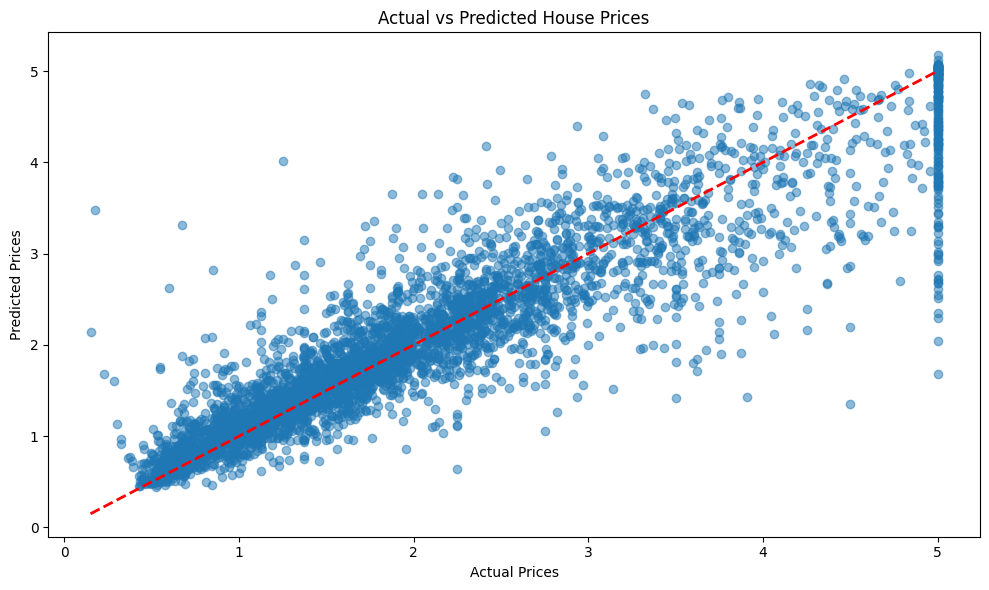

In [8]:
# Make predictions
y_pred = model.predict(X_test_featured)

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.tight_layout()
plt.show()

## 6. Save Model and Transformers

In [9]:
import os
from pathlib import Path

# Get project root directory
project_root = Path.cwd().parent
model_dir = project_root / 'model'
os.makedirs(model_dir, exist_ok=True)

# Save the trained model, scaler, and feature transformers for future use
# Ensuring the model and preprocessing pipeline can be reused for predictions or further analysis
joblib.dump(model, model_dir / 'house_price_model.joblib')
joblib.dump(scaler, model_dir / 'scaler.joblib')
joblib.dump(feature_transformers, model_dir / 'feature_transformers.joblib')
print("Model and transformers saved successfully!")

Model and transformers saved successfully!
